# Calibration of the pixel position for a Pilatus detector

This tutorial summarizes the work done by Frederic Sulzman during his internship at ESRF during the summer 2015 entilted "Calibration for geometric distortion in multi-
modules pixel detectors".

The overall strategy is very similar to "CCD calibration" tutorial with some specificities due to the modular nature of the detector.

0. Image preprocessing
1. Peak picking
2. grid assignment
3. displacement fitting
4. reconstruction of the pixel position
5. saving into a detector definition file

Each module being made by lithographic processes, the error within a module will be assumeed to be constant. We will use the name "displacement of the module" to describe the rigide movement of the module.

This tutorial uses data from the Pilatus3 2M CdTe from the ID15 beam line of the ESRF. 
They provided not only the intersnip subject but also the couple of images uses to calibrate the detector.

This detector contains 48 half-modules, each bound to a single CdTe monocrystal sensor and is designed for high energy X-ray radiation detection. 
Due to the construction procedure, these half-modules could show a misalignment within the detector
plane. 
While the manufacturer (Dectris) garanties a precision within a pixel (172µm), the miss-alignment of certain modules can be seen while calibrating Debye-Scherrer ring using refereance sample. 
So the aim of this work is to provide a detector description with a better precision better than the original detector.

This work will be performed on the image of a grid available:
http://www.silx.org/pub/pyFAI/detector_calibration/Pilatus2MCdTe_ID15_grid_plus_sample_0004.cbf
and the scattering of ceria (CeO2) at 72.1keV available here.
http://www.silx.org/pub/pyFAI/detector_calibration/Pilatus2MCdTe_ID15_CeO2_72100eV_800mm_0000.cbf

It is a good exercise to calibrate all rings of the later image using the *pyFAI-calib2* tool. 
A calibration close to perfection is needed to visualize the module miss-alignement we aim at correcting.

In [2]:
%matplotlib notebook

In [31]:
#many imports which will be used all along the notebook
import time
start_time = time.time()
import os
import pyFAI
import fabio
import glob
import numpy
from scipy.ndimage import convolve, binary_dilation
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
from matplotlib.pyplot import subplots
from pyFAI.ext.bilinear import Bilinear
from pyFAI.ext.watershed import InverseWatershed
from silx.resources import ExternalResources

print("Using pyFAI verison: ", pyFAI.version)

Using pyFAI verison:  0.18.0-dev0


In [4]:
#Nota: comment out when running from outside ESRF
os.environ["http_proxy"] = "http://proxy.esrf.fr:3128"

In [5]:
downloader = ExternalResources("detector_calibration", "http://www.silx.org/pub/pyFAI/detector_calibration/")
ring_file = downloader.getfile("Pilatus2MCdTe_ID15_CeO2_72100eV_800mm_0000.cbf")
print(ring_file)
grid_file = downloader.getfile("Pilatus2MCdTe_ID15_grid_plus_sample_0004.cbf")
print(grid_file)

/tmp/detector_calibration_testdata_kieffer/Pilatus2MCdTe_ID15_CeO2_72100eV_800mm_0000.cbf
/tmp/detector_calibration_testdata_kieffer/Pilatus2MCdTe_ID15_grid_plus_sample_0004.cbf


<IPython.core.display.Javascript object>


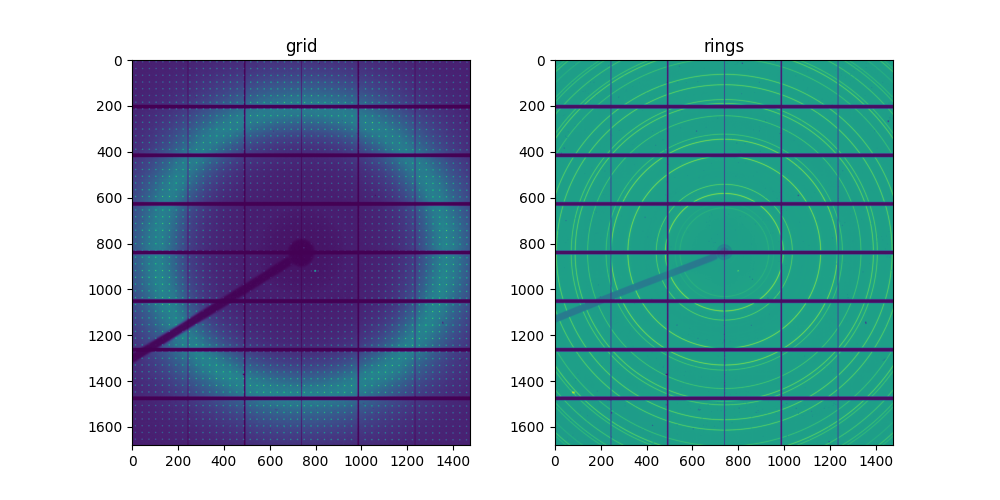

Text(0.5, 1.0, 'rings')

In [6]:
rings = fabio.open(ring_file).data
img = fabio.open(grid_file).data
fig,ax = subplots(1,2, figsize=(10,5))
ax[0].imshow(img.clip(0,1000), interpolation="bilinear")
ax[0].set_title("grid")
ax[1].imshow(numpy.arcsinh(rings), interpolation="bilinear")
ax[1].set_title("rings")

## Image processing

There are 3 pre-processing steps which are needed.

1. Define for each module a unique identifier which will be used later on during the fitting procedure
2. Define the proper mask: each module is the assembly of 4x2 sub-modules and there are (3) interpolated pixels between each sub-module, such "unreliable pixels should be masked out as well
3. Correct the grid image by the smoothed image to have a constant background.
4. Convolve the raw image with a typical hole shape to allow a precise spotting of the hole center.


In [16]:
# This is the default detector as definied in pyFAI according to the specification provided by Dectris:
pilatus = pyFAI.detector_factory("Pilatus_2m_CdTe")
print(pilatus)

mask1 = pilatus.mask
module_size = pilatus.MODULE_SIZE
module_gap = pilatus.MODULE_GAP
submodule_size = (96,60)

Detector Pilatus CdTe 2M	 PixelSize= 1.720e-04, 1.720e-04 m


In [17]:
#1 + 2 Calculation of the module_id and the interpolated-mask:
mid = numpy.zeros(pilatus.shape, dtype=int)
mask2 = numpy.zeros(pilatus.shape, dtype=int)
idx = 1
for i in range(8):
    y_start = i*(module_gap[0] + module_size[0])
    y_stop = y_start + module_size[0]
    for j in range(3):
        x_start = j*(module_gap[1] + module_size[1])
        x_stop = x_start + module_size[1]
        mid[y_start:y_stop,x_start: x_start+module_size[1]//2] = idx
        idx+=1
        mid[y_start:y_stop,x_start+module_size[1]//2: x_stop] = idx
        idx+=1
        mask2[y_start+submodule_size[0]-1:y_start+submodule_size[0]+2,
              x_start:x_stop] = 1
        for k in range(1,8):
            mask2[y_start:y_stop,
              x_start+k*(submodule_size[1]+1)-1:x_start+k*(submodule_size[1]+1)+2] = 1

In [18]:
#Extra masking
mask0 = img<0
#Those pixel are miss-behaving... they are the hot islet next to the beam-stop
mask0[915:922,793:800] = 1
mask0[817:820,747:750] = 1

<IPython.core.display.Javascript object>


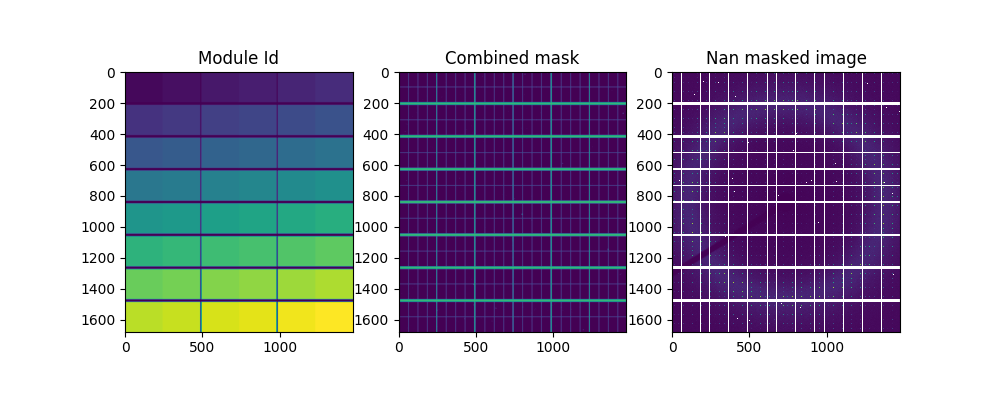

Text(0.5, 1.0, 'Nan masked image')

In [19]:
fig,ax = subplots(1,3, figsize=(10,4))
ax[0].imshow(mid, interpolation="bilinear")
ax[0].set_title("Module Id")

ax[1].imshow(mask2+mask1+mask0, interpolation="bilinear")
ax[1].set_title("Combined mask")

nimg = img.astype(float)
nimg[numpy.where(mask0+mask1+mask2)] = numpy.nan


ax[2].imshow(nimg)#, interpolation="bilinear")
ax[2].set_title("Nan masked image")

In [20]:
# The Nan-masked image contains now only valid values (and Nan elsewhere). We will make a large median filter to 
# build up a smooth image without gaps.
#
# This function is backported from future version of numpy ... it allows to expose a winbowed view 
# to perform the nanmedian-filter
from numpy.lib.stride_tricks import as_strided
def sliding_window_view(x, shape, subok=False, readonly=True):
    """
    Creates sliding window views of the N dimensional array with the given window
    shape. Window slides across each dimension of `x` and extract subsets of `x`
    at any window position.
    Parameters
    ----------
    x : array_like
        Array to create sliding window views of.
    shape : sequence of int
        The shape of the window. Must have same length as the number of input array dimensions.
    subok : bool, optional
        If True, then sub-classes will be passed-through, otherwise the returned
        array will be forced to be a base-class array (default).
    readonly : bool, optional
        If set to True, the returned array will always be readonly view.
        Otherwise it will return writable copies(see Notes).
    Returns
    -------
    view : ndarray
        Sliding window views (or copies) of `x`. view.shape = x.shape - shape + 1
    See also
    --------
    as_strided: Create a view into the array with the given shape and strides.
    broadcast_to: broadcast an array to a given shape.
    Notes
    -----
    ``sliding_window_view`` create sliding window views of the N dimensions array
    with the given window shape and its implementation based on ``as_strided``.
    Please note that if readonly set to True, views are returned, not copies
    of array. In this case, write operations could be unpredictable, so the returned
    views are readonly. Bear in mind that returned copies (readonly=False) will
    take more memory than the original array, due to overlapping windows.
    For some cases there may be more efficient approaches to calculate transformations
    across multi-dimensional arrays, for instance `scipy.signal.fftconvolve`, where combining
    the iterating step with the calculation itself while storing partial results can result
    in significant speedups.
    Examples
    --------
    >>> i, j = np.ogrid[:3,:4]
    >>> x = 10*i + j
    >>> shape = (2,2)
    >>> np.lib.stride_tricks.sliding_window_view(x, shape)
    array([[[[ 0,  1],
             [10, 11]],
            [[ 1,  2],
             [11, 12]],
            [[ 2,  3],
             [12, 13]]],
           [[[10, 11],
             [20, 21]],
            [[11, 12],
             [21, 22]],
            [[12, 13],
             [22, 23]]]])
    """
    np = numpy
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    try:
        shape = np.array(shape, np.int)
    except:
        raise TypeError('`shape` must be a sequence of integer')
    else:
        if shape.ndim > 1:
            raise ValueError('`shape` must be one-dimensional sequence of integer')
        if len(x.shape) != len(shape):
            raise ValueError("`shape` length doesn't match with input array dimensions")
        if np.any(shape <= 0):
            raise ValueError('`shape` cannot contain non-positive value')

    o = np.array(x.shape) - shape  + 1 # output shape
    if np.any(o <= 0):
        raise ValueError('window shape cannot larger than input array shape')

    if type(readonly) != bool:
        raise TypeError('readonly must be a boolean')

    strides = x.strides
    view_strides = strides

    view_shape = np.concatenate((o, shape), axis=0)
    view_strides = np.concatenate((view_strides, strides), axis=0)
    view = as_strided(x, view_shape, view_strides, subok=subok, writeable=not readonly)

    if not readonly:
        return view.copy()
    else:
        return view

(1679, 1475)
(1697, 1485)
(1679, 1475)


<IPython.core.display.Javascript object>


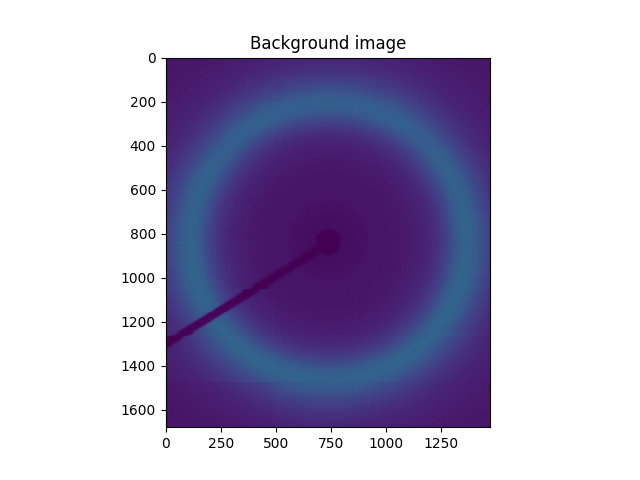

CPU times: user 23.1 s, sys: 6.54 s, total: 29.6 s
Wall time: 29.6 s


In [22]:
%%time 
#Calculate a background image using a large median filter ... takes a while
shape = (19,11)
print(nimg.shape)
padded = numpy.pad(nimg, tuple((i//2,) for i in shape), mode="edge")
print(padded.shape)
background = numpy.nanmedian(sliding_window_view(padded,shape), axis = (-2,-1))
print(background.shape)
fig,ax = subplots()
ax.imshow(background)
ax.set_title("Background image")

<IPython.core.display.Javascript object>


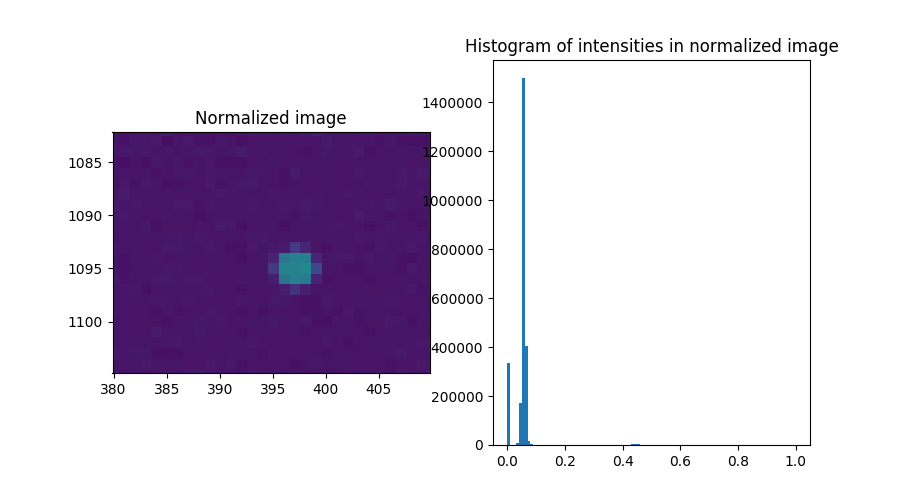

0.0 17.728813559322035


Text(0.5, 1.0, 'Histogram of intensities in normalized image')

In [23]:
fig,ax = subplots(1,2, figsize=(9,5))

normalized = (nimg/background)

low = numpy.nanmin(normalized)
high = numpy.nanmax(normalized)
print(low, high)
normalized[numpy.isnan(normalized)] = 0
normalized /= high

ax[0].imshow(normalized)
ax[0].set_title("Normalized image")

ax[1].hist(normalized.ravel(), 100, range=(0,1))
ax[1].set_title("Histogram of intensities in normalized image")

For a precise measurement of the peak position, one trick is to convolve the image with a pattern which looks like a hole of the grid.


<IPython.core.display.Javascript object>


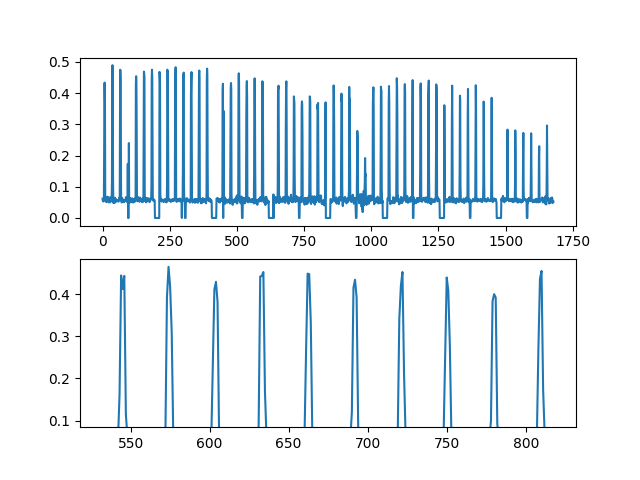

In [24]:
#print the profile of the normalized image: the center is difficult to measure due to the small size of the hole.
fig,ax = subplots(2)
ax[0].plot(normalized[:,545])
ax[1].plot(normalized[536,:])

19.63857792789662


<IPython.core.display.Javascript object>


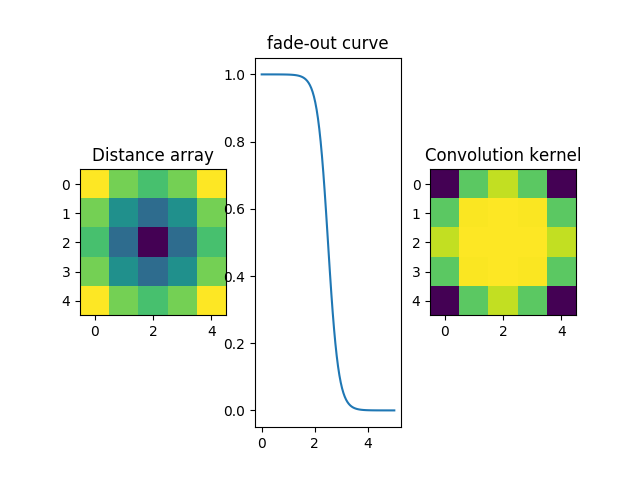

Text(0.5, 1.0, 'Convolution kernel')

In [25]:
#Definition of the convolution kernel
ksize = 5
y,x = numpy.ogrid[-(ksize-1)//2:ksize//2+1,-(ksize-1)//2:ksize//2+1]
d = numpy.sqrt(y*y+x*x)

#Fade out curve definition
fadeout = lambda x: 1/(1+numpy.exp(5*(x-2.5)))

kernel = fadeout(d)
mini=kernel.sum()
print(mini)

fig,ax = subplots(1,3)
ax[0].imshow(d)
ax[0].set_title("Distance array")

ax[1].plot(numpy.linspace(0,5,100),fadeout(numpy.linspace(0,5,100)))
ax[1].set_title("fade-out curve")

ax[2].imshow(kernel)
ax[2].set_title("Convolution kernel")


(1679, 1475)


<IPython.core.display.Javascript object>


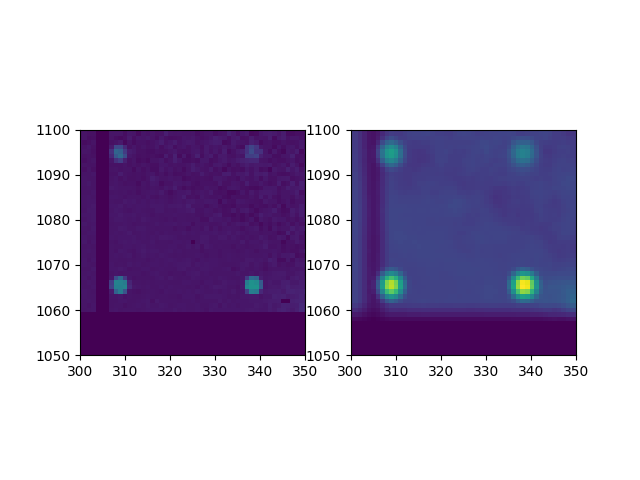

(array([1065]), array([338]))

In [27]:
my_smooth = convolve(normalized, kernel, mode="constant", cval=0)/mini
print(my_smooth.shape)
fig,ax = subplots(1,2)
ax[0].imshow(normalized.clip(0,1))
ax[0].set_ylim(1050,1100)
ax[0].set_xlim(300,350)
ax[1].imshow(my_smooth.clip(0,1))
ax[1].set_ylim(1050,1100)
ax[1].set_xlim(300,350)
numpy.where(my_smooth == my_smooth.max())

335009
782371


<IPython.core.display.Javascript object>


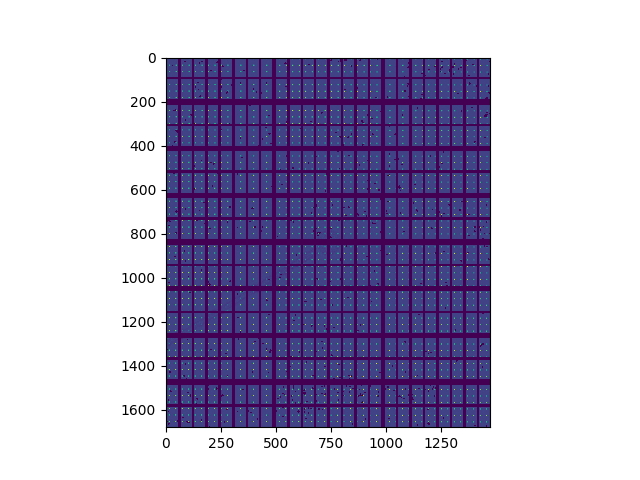

In [29]:
#mask out all pixels too close to any masked position

all_masks = numpy.logical_or(numpy.logical_or(mask0,mask1),mask2)
print(all_masks.sum())
big_mask = binary_dilation(all_masks, iterations=ksize//2+1+1)
print(big_mask.sum())
smooth2 = my_smooth.copy()
smooth2[big_mask] = 0
fig,ax = subplots()
ax.imshow(smooth2)

<IPython.core.display.Javascript object>


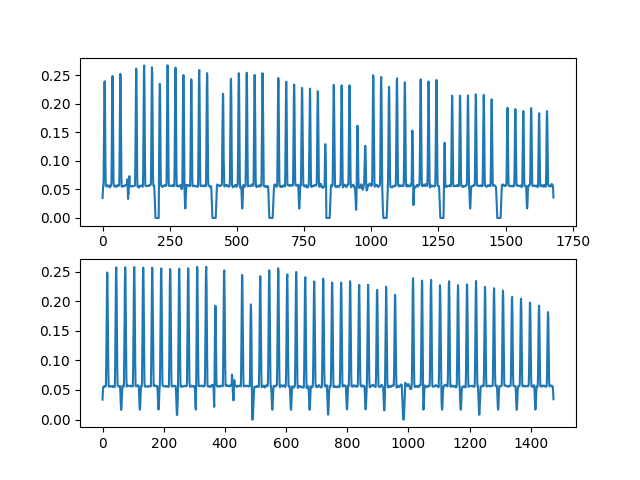

In [30]:
#Display the profile of the smoothed image: the center is easy to measure thanks to the smoothness of the signal
fig,ax = subplots(2)
ax[0].plot(my_smooth[:,545])
ax[1].plot(my_smooth[536,:])

## Peak picking

We use the watershed module from *pyFAI* to retrieve all peak positions.
Those regions are sieved out respectively for:

* their size, it should be larger than the kernel itself
* the peaks too close to masked regions are removed
* the intensity of the peak



In [33]:
iw = InverseWatershed(my_smooth)
iw.init()
iw.merge_singleton()
all_regions = set(iw.regions.values())

regions = [i for i in all_regions if i.size>mini]

print("Number of region segmented: %s"%len(all_regions))
print("Number of large enough regions : %s"%len(regions))


Number of region segmented: 82126
Number of large enough regions : 41333


In [34]:
#Remove peaks on masked region
sieved_region = [i for i in regions if not big_mask[(i.index//nimg.shape[-1], i.index%nimg.shape[-1])]]
print("Number of peaks not on masked areea : %s"%len(sieved_region))

Number of peaks not on masked areea : 30001


<IPython.core.display.Javascript object>


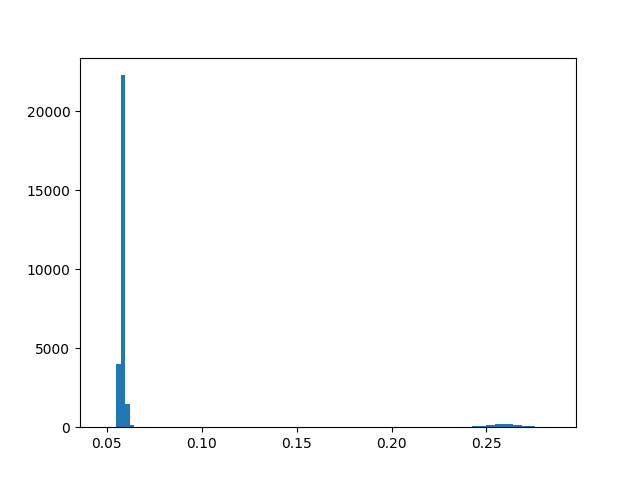

(array([1.0000e+00, 0.0000e+00, 1.0000e+01, 3.9940e+03, 2.2274e+04,
        1.4800e+03, 1.1700e+02, 3.4000e+01, 8.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 3.00

In [35]:
# Histogram of peak height:
s = numpy.array([i.maxi for i in sieved_region])

fig, ax = subplots()
ax.hist(s, 100)

In [38]:
#sieve out for peak intensity
peaks = [(i.index//nimg.shape[-1], i.index%nimg.shape[-1]) for i in sieved_region if (i.maxi)>0.1]
print("Number of remaining peaks: %s"%len(peaks))

peaks_raw = numpy.array(peaks)

Number of remaining peaks: 2075


<IPython.core.display.Javascript object>


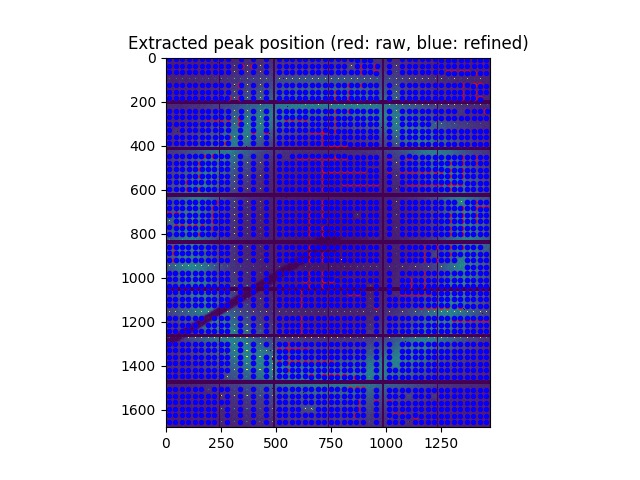

Refined peak coordinate:
[(67.40814486145973, 1368.5667790174484), (1535.3543709814548, 14.551862001419067), (359.43239176273346, 133.56951662898064), (359.56447544693947, 163.18037773668766), (359.5204519331455, 192.6839124560356), (359.68160489201546, 221.83503724634647), (359.65108612179756, 251.14785888791084), (7.186804354190826, 16.41273033618927), (7.231230393052101, 45.745011150836945), (7.290591448545456, 75.19019249081612)]


In [39]:
# Finally the peak positions are interpolated using a second order taylor expansion 
# in thevinicy of the maximum value of the signal:

#Create bilinear interpolator
bl = Bilinear(my_smooth)

#Overlay raw peak coordinate and refined peak positions

ref_peaks = [bl.local_maxi(p) for p in peaks]
fig, ax = subplots()
ax.imshow(img.clip(0,1000), interpolation="nearest")
peaks_ref = numpy.array(ref_peaks)
ax.plot(peaks_raw[:,1], peaks_raw[:, 0], ".r")
ax.plot(peaks_ref[:,1],peaks_ref[:, 0], ".b")
ax.set_title("Extracted peak position (red: raw, blue: refined)")
print("Refined peak coordinate:")
print(ref_peaks[:10])
